In [9]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from pathlib import Path

In [10]:

# for dirname, _, filenames in os.walk('./chest_xray'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [11]:
# Define path to the data directory
dir_alldata = Path('./chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

In [12]:
img_width, img_height = 150,150
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150),batch_size=batch_size, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")
 
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


c:\users\cristi\pycharmprojects\x_ray\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

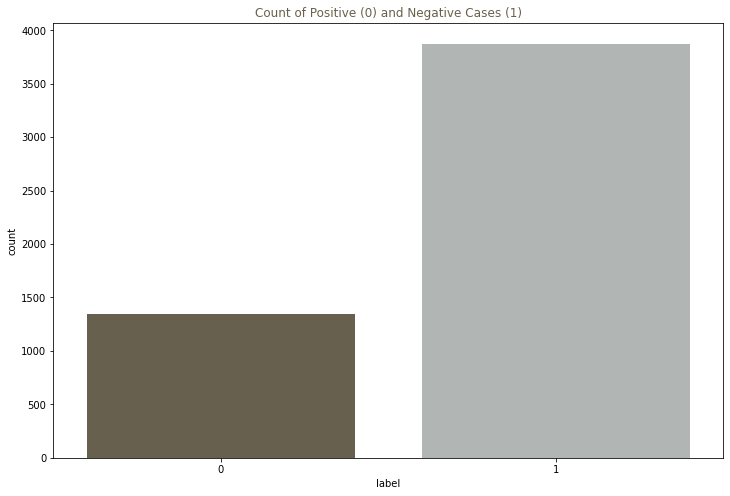

In [13]:
# To plot the count plot I am changing the dataset into a pandas dataframe
# Get the list of all the images
normal = normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)", color="#6B614B")

In [14]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)       

In [15]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_sample//batch_size, epochs=epochs,validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size)

c:\users\cristi\pycharmprojects\x_ray\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 9s 160ms/step - loss: 0.6059 - accuracy: 0.7060 - val_loss: 0.7261 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 8s 154ms/step - loss: 0.4986 - accuracy: 0.7850

In [17]:
test_accuracy = model.evaluate_generator(test_generator)

c:\users\cristi\pycharmprojects\x_ray\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [18]:
print('The accuracy on test set :',test_accuracy[1]*100 )


The accuracy on test set : 88.30128312110901
